In [1]:
from e3nn import o3
from e3nn.util.test import assert_equivariant
import torch

In [2]:
"""Cell to determine the input irreps"""
# Compare the types of tensor products
irrep_in = "1x0e + 1x1o + 1x2e"
o3_type = o3.Irreps(irrep_in)
print(f"Dimension of the input: {o3_type.dim}")

x = torch.tensor([1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
y = torch.tensor([0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 3.0, 2.0, 1.0])

# Full Tensor Product
print("Full Tensor Product")
ftp = o3.FullTensorProduct(o3_type, o3_type)
out = ftp(x, y)
print(f"Dimension of the output: {out.shape}")
print(f"Output irreps: {ftp.irreps_out}")

print("Reduced Tensor Product")
rtp = o3.ReducedTensorProducts("ij=ji", i=irrep_in)
out = rtp(x, y)
print(f"Dimension of the output: {out.shape}")
print(f"Output irreps: {rtp.irreps_out}")

Dimension of the input: 9
Full Tensor Product
Dimension of the output: torch.Size([81])
Output irreps: 1x0e+1x0e+1x0e+1x1o+1x1o+1x1o+1x1o+1x1e+1x1e+1x2o+1x2o+1x2e+1x2e+1x2e+1x2e+1x3o+1x3o+1x3e+1x4e
Reduced Tensor Product


/Users/sudarshanvijay/miniconda3/envs/molml/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


Dimension of the output: torch.Size([45])
Output irreps: 3x0e+2x1o+1x2o+3x2e+1x3o+1x4e


In [3]:
print("Performing full tensor product")
irrep_symmetric_matrix = o3.Irreps("3x0e+2x1o+1x2o+3x2e+1x3o+1x4e")
ftp_of_symm_matrices = o3.FullTensorProduct(
    irrep_symmetric_matrix, irrep_symmetric_matrix
)
# ftp_of_symm_matrices.visualize()
print(f"Dimension of the output: {ftp_of_symm_matrices.irreps_out.dim}")
print(f"Output irreps: {ftp_of_symm_matrices.irreps_out}")
print(f"ftp_of_symm_matrices(x, y): {ftp_of_symm_matrices}")

Performing full tensor product
Dimension of the output: 2025
Output irreps: 3x0o+3x0o+9x0e+4x0e+1x0e+9x0e+1x0e+1x0e+6x1o+6x1o+6x1o+3x1o+6x1o+3x1o+3x1o+3x1o+1x1o+1x1o+4x1e+2x1e+2x1e+1x1e+1x1e+9x1e+1x1e+1x1e+1x1e+3x2o+6x2o+3x2o+3x2o+1x2o+6x2o+3x2o+3x2o+3x2o+1x2o+1x2o+1x2o+9x2e+4x2e+2x2e+2x2e+2x2e+1x2e+1x2e+9x2e+9x2e+3x2e+2x2e+1x2e+1x2e+3x2e+1x2e+3x3o+6x3o+2x3o+3x3o+1x3o+6x3o+3x3o+3x3o+3x3o+3x3o+1x3o+2x3o+1x3o+1x3o+2x3e+2x3e+2x3e+1x3e+1x3e+9x3e+3x3e+2x3e+1x3e+1x3e+3x3e+1x3e+2x4o+3x4o+1x4o+3x4o+3x4o+3x4o+1x4o+2x4o+1x4o+1x4o+3x4e+2x4e+1x4e+1x4e+9x4e+3x4e+2x4e+1x4e+1x4e+3x4e+3x4e+1x4e+2x5o+1x5o+3x5o+3x5o+1x5o+2x5o+1x5o+1x5o+1x5e+3x5e+1x5e+1x5e+3x5e+1x5e+1x6o+1x6o+1x6o+1x6o+3x6e+1x6e+3x6e+1x6e+1x7o+1x7o+1x7e+1x8e
ftp_of_symm_matrices(x, y): FullTensorProduct(3x0e+2x1o+1x2o+3x2e+1x3o+1x4e x 3x0e+2x1o+1x2o+3x2e+1x3o+1x4e -> 6x0o+25x0e+38x1o+22x1e+34x2o+50x2e+38x3o+28x3e+20x4o+30x4e+14x5o+10x5e+4x6o+8x6e+2x7o+1x7e+1x8e | 331 paths | 0 weights)


In [6]:
# Generate a 9x9 symmetric matrix
symmetric_matrix_1 = torch.randn(9, 9)
symmetric_matrix_1 = (symmetric_matrix_1 + symmetric_matrix_1.T) / 2
symmetric_matrix_2 = torch.randn(9, 9)
symmetric_matrix_2 = (symmetric_matrix_2 + symmetric_matrix_2.T) / 2

# Create the input and output irreps
irreps_out_symm_matrix = o3.Irreps("6x0o+25x0e+38x1o+22x1e+34x2o+50x2e")
print(f"Irreps out of the output: {irreps_out_symm_matrix}")
print(f"Dimension of the output: {o3.Irreps(irreps_out_symm_matrix).dim}")

Irreps out of the output: 6x0o+25x0e+38x1o+22x1e+34x2o+50x2e
Dimension of the output: 631


Performing fully connected tensor product


(<Figure size 432x288 with 1 Axes>, <AxesSubplot: >)

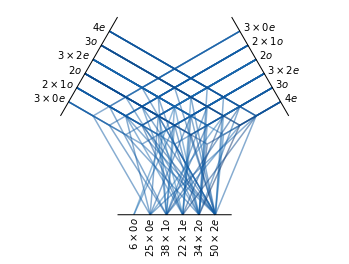

In [7]:
print("Performing fully connected tensor product")
fctp_of_symm_matrices = o3.FullyConnectedTensorProduct(
    irrep_symmetric_matrix, irrep_symmetric_matrix, irreps_out_symm_matrix
)
fctp_of_symm_matrices.visualize()

In [8]:
assert_equivariant(
    irreps_in=[irrep_symmetric_matrix, irrep_symmetric_matrix],
    irreps_out=irreps_out_symm_matrix,
    func=fctp_of_symm_matrices,
)

{(0, False): tensor([1.7137e-06]), (1, False): tensor([1.1932e-06])}

In [9]:
# Generate the 45 element vector from the symmetric matrix
def generate_equi_rep_from_matrix(matrix):
    """Take out the relevant parts of the symmetric matrix to generate the 45 element vector"""
    s_comp = matrix[0:1, 0:1]
    p_comp = matrix[1:4, 1:4]
    d_comp = matrix[4:, 4:]
    sp_comp = matrix[0:1, 1:4]
    sd_comp = matrix[0:1, 4:]
    pd_comp = matrix[1:4, 4:]

    def create_voigt_notation_vector(component):
        """For a given component, create the voigt notation vector"""
        diagonal = torch.diagonal(component)
        off_diagonal = torch.triu(component, diagonal=1)
        off_diagonal = off_diagonal[off_diagonal != 0]
        return torch.cat([diagonal, off_diagonal])

    # Create the voigt notation vector for the s_component, p_component, d_component
    s_contrib = create_voigt_notation_vector(s_comp)
    p_contrib = create_voigt_notation_vector(p_comp)
    d_contrib = create_voigt_notation_vector(d_comp)

    # Flatten the sp, sd, pd components
    sp_contrib = sp_comp.flatten()
    sd_contrib = sd_comp.flatten()
    pd_contrib = pd_comp.flatten()

    # Concatenate the components to get the 45 element vector
    equi_rep = torch.cat(
        [s_contrib, p_contrib, d_contrib, sp_contrib, sd_contrib, pd_contrib]
    )

    return equi_rep

In [10]:
equi_rep_1 = generate_equi_rep_from_matrix(symmetric_matrix_1)
equi_rep_2 = generate_equi_rep_from_matrix(symmetric_matrix_2)

# Take the tensor product of the 45 element vectors
output_tp = fctp_of_symm_matrices(equi_rep_1, equi_rep_2)

In [11]:
# Test equivariance based on the data generated above
angles = o3.rand_angles()
D_g = irrep_symmetric_matrix.D_from_angles(*angles)
D_prime_g = irreps_out_symm_matrix.D_from_angles(*angles)

applied_to_inputs = fctp_of_symm_matrices(D_g @ equi_rep_1, D_g @ equi_rep_2)
applied_to_outputs = D_prime_g @ fctp_of_symm_matrices(equi_rep_1, equi_rep_2)
difference = applied_to_inputs - applied_to_outputs
print(f"Maximum absolute difference: {torch.max(torch.abs(difference))}")

Maximum absolute difference: 2.5033950805664062e-06
